In [1]:
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from matplotlib import cm

from skimage import color, measure
from skimage.transform import hough_circle
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.color import rgb2gray
from skimage.io import imread

from __future__ import print_function

In [2]:
Tot = np.load('3st_3fl_nw_10m.npy')

In [3]:
Full = max(Tot[:,3])
FullE = Tot[Tot[:,3]==Full] #Creates array of only full energy deposition
Conc = Tot[(Tot[:,3]<Full) & (Tot[:,6]>0)] #Creates array of less than full energy deposition - Concrete Scattered
Asph = Tot[(Tot[:,3]<Full) & (Tot[:,6]<=0)] #Creates array of less than full energy deposition - Asphault Scattered

In [4]:
# intersection function
def isect_line_plane_v3(p0, p1, p_co, p_no, epsilon=1e-6):
    """
    p0, p1: define the line - p0 is last point in air/material and p1 is detector interaction point
    p_co, p_no: define the plane:
        p_co is a point on the plane (plane coordinate).
        p_no is a normal vector defining the plane direction;
             (does not need to be normalized).

    return a Vector or None (when the intersection can't be found).
    """

    u = p0-p1
    dot = np.dot(p_no, u)

    if abs(dot) > epsilon:
        # the factor of the point between p0 -> p1 (0 - 1)
        # if 'fac' is between (0 - 1) the point intersects with the segment.
        # otherwise:
        #  < 0.0: behind p0.
        #  > 1.0: infront of p1.
        w = p0-p_co
        fac = -np.dot(p_no, w) / dot
        u = u*fac
        return p0+u
    else:
        # The segment is parallel to plane
        return None

In [5]:
def inters(surf): #finds where gamma particle departs surface
    intersections = []
    for i in range(len(surf)):
        spoint=np.array([surf[:,4][i], surf[:,5][i], surf[:,6][i]]) #last known point in material
        hpoint=np.array([surf[:,0][i], surf[:,1][i], surf[:,2][i]]) #hit point on detector
        o = isect_line_plane_v3(spoint,hpoint, p1, cp)
        intersections.append(o)
    return intersections

In [6]:
Roof = Tot[(Tot[:,6]>890)] #Creates array of interactions in the Roof - Total Detector Response
North = Tot[(Tot[:,7]<135) & (Tot[:,7]>45) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the North Wall
South = Tot[(Tot[:,7]<-45) & (Tot[:,7]>-135) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the South Wall
East = Tot[(Tot[:,7]<45) & (Tot[:,7]>-45) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the East Wall
West1 = Tot[(Tot[:,7]<-135) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the West Wall 
West2 = Tot[(Tot[:,7]>135) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the West Wall
West = np.vstack((West1,West2))
FullRoof = Tot[(Tot[:,6]>890) & (Tot[:,3]==Full)] #Creates array of interactions in the Roof - Full Energy Deposition
FullNorth = Tot[(Tot[:,7]<135) & (Tot[:,7]>45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the North Wall
FullSouth = Tot[(Tot[:,7]<-45) & (Tot[:,7]>-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the South Wall
FullEast = Tot[(Tot[:,7]<45) & (Tot[:,7]>-45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the East Wall
FullWest1 = Tot[(Tot[:,7]<-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the West Wall 
FullWest2 = Tot[(Tot[:,7]>135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the West Wall
FullWest = np.vstack((FullWest1,FullWest2))
PartRoof = Tot[(Tot[:,6]>890) & (Tot[:,3]<Full)] #Creates array of interactions in the Roof - Partial Energy Deposition
PartNorth = Tot[(Tot[:,7]<135) & (Tot[:,7]>45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the North Wall
PartSouth = Tot[(Tot[:,7]<-45) & (Tot[:,7]>-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the South Wall
PartEast = Tot[(Tot[:,7]<45) & (Tot[:,7]>-45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the East Wall
PartWest1 = Tot[(Tot[:,7]<-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the West Wall 
PartWest2 = Tot[(Tot[:,7]>135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the West Wall
PartWest = np.vstack((PartWest1,PartWest2))

In [7]:
#Defining North Wall Surface
p1 = np.array([0, 310, 0]) #Bottom Center Point
p2 = np.array([-255, 310, 1000]) #Top Left Point
p3 = np.array([255, 310, 1000]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [8]:
intersections = inters(North)
tnx,tny,tnz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
NorthTot, _, __ = np.histogram2d(tnx,tnz, bins=[xedges, yedges])

In [9]:
intersections = inters(FullNorth)
fnx,fny,fnz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
NorthFull, _, __ = np.histogram2d(fnx,fnz, bins=[xedges, yedges])

In [10]:
intersections = inters(PartNorth)
pnx,pny,pnz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
NorthPart, _, __ = np.histogram2d(pnx,pnz, bins=[xedges, yedges])

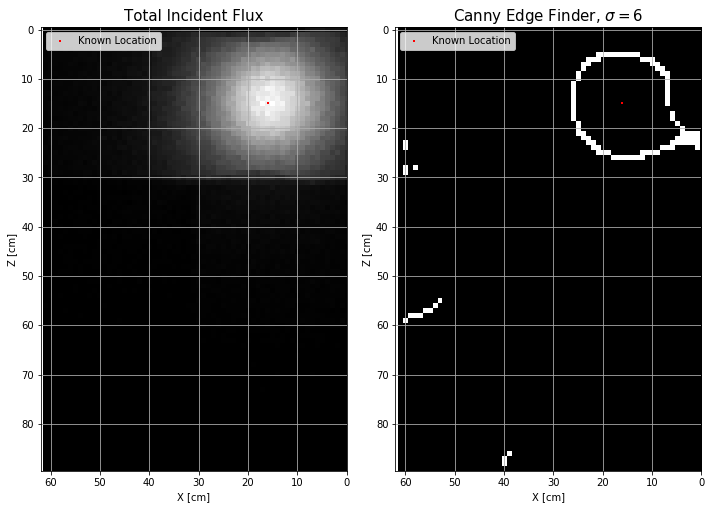

In [11]:
img = np.flipud(NorthTot.T)

# Compute the Canny filter for two values of sigma
edges1 = canny(img, sigma=6)

# display results
plt.clf()
plt.figure(figsize=(10,7))

plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
plt.scatter(16, 15, s=5, c='r', marker="+" ,label='Known Location')
plt.xlim(62,0)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Total Incident Flux', fontsize=15)

plt.subplot(122)
plt.imshow(edges1, cmap=plt.cm.gray)
plt.scatter(16, 15, s=5, c='r', marker="+", label='Known Location')
plt.xlim(62,0)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Canny Edge Finder, $\sigma=6$', fontsize=15)

plt.tight_layout()
plt.savefig('Images/Centroids/1Canny_Total_3fl_NW_10m.png', bbox_inches='tight')
plt.show()


(15.15949297261573, 16.126767315091925, 10.452358080710821)


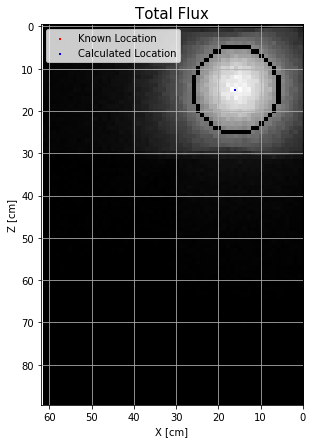

In [12]:
edges = canny(img, sigma=6)
coords = np.column_stack(np.nonzero(edges))

model, inliers = measure.ransac(coords, measure.CircleModel, min_samples=3, residual_threshold=1, max_trials=1000)

print(model.params)

rr, cc = circle_perimeter(int(model.params[0]), int(model.params[1]), int(model.params[2]), shape=img.shape)

img[rr, cc] = 1

plt.clf()
plt.figure(figsize=(10,7))
plt.imshow(img, cmap='gray')
plt.scatter(16, 15, s=5, c='r', marker="+", label='Known Location')
plt.scatter(model.params[1], model.params[0], s=5, c='b', marker="+", label='Calculated Location')
plt.grid(True)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.xlim(62,0)
plt.title('Total Flux', fontsize=15)
plt.legend(loc='upper left')
plt.savefig('Images/Centroids/2Cent_Total_3fl_NW_10m.png', bbox_inches='tight')
plt.show()

In [13]:
d_error = (((16-model.params[1])**2)+((15-model.params[0])**2))*10
print(d_error)

0.4150796048941753


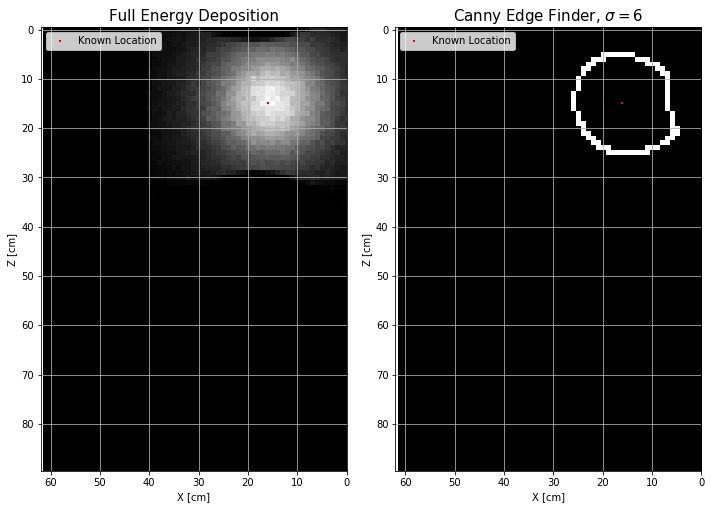

In [14]:
img1 = np.flipud(NorthFull.T)

# Compute the Canny filter for two values of sigma
edges1 = canny(img1, sigma=6)

# display results
plt.clf()
plt.figure(figsize=(10,7))

plt.subplot(121)
plt.imshow(img1, cmap=plt.cm.gray)
plt.scatter(16, 15, s=5, c='r', marker="+" ,label='Known Location')
plt.xlim(62,0)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Full Energy Deposition', fontsize=15)

plt.subplot(122)
plt.imshow(edges1, cmap=plt.cm.gray)
plt.scatter(16, 15, s=5, c='r', marker="+", label='Known Location')
plt.xlim(62,0)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Canny Edge Finder, $\sigma=6$', fontsize=15)

plt.tight_layout()
plt.savefig('Images/Centroids/1Canny_Full_3fl_NW_10m.png', bbox_inches='tight')
plt.show()

(15.064748754297483, 15.548869266610197, 10.235103074034633)


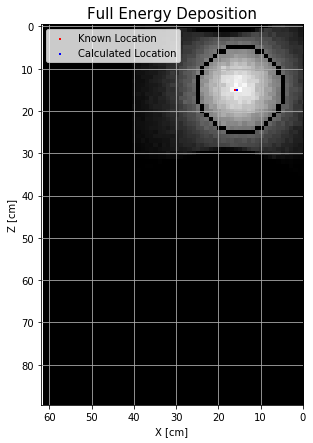

In [15]:
edges = canny(img1, sigma=6)
coords = np.column_stack(np.nonzero(edges))

model, inliers = measure.ransac(coords, measure.CircleModel, min_samples=3, residual_threshold=1, max_trials=1000)

print(model.params)

rr, cc = circle_perimeter(int(model.params[0]), int(model.params[1]), int(model.params[2]), shape=img1.shape)

img1[rr, cc] = 1

plt.clf()
plt.figure(figsize=(10,7))
plt.imshow(img1, cmap='gray')
plt.scatter(16, 15, s=5, c='r', marker="+", label='Known Location')
plt.scatter(model.params[1], model.params[0], s=5, c='b', marker="+", label='Calculated Location')
plt.grid(True)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.xlim(62,0)
plt.title('Full Energy Deposition', fontsize=15)
plt.legend(loc='upper left')
plt.savefig('Images/Centroids/2Cent_Full_3fl_NW_10m.png', bbox_inches='tight')
plt.show()

In [16]:
d_error = (((16-model.params[1])**2)+((15-model.params[0])**2))*10
print(d_error)

2.0771133979189744


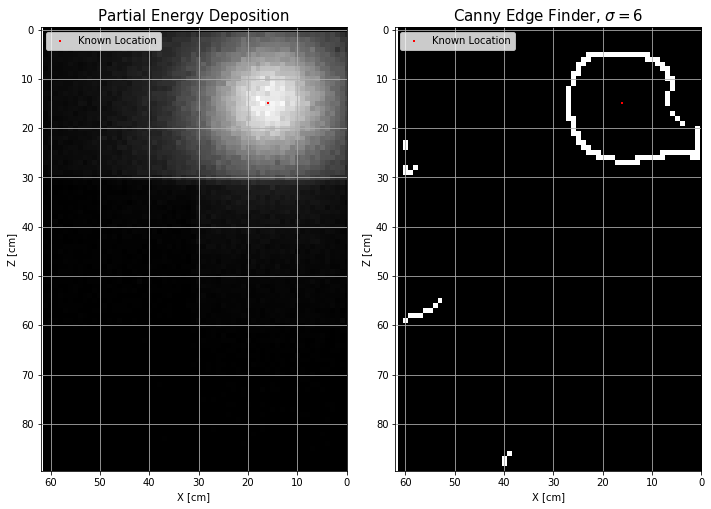

In [17]:
img2 = np.flipud(NorthPart.T)

# Compute the Canny filter for two values of sigma
edges1 = canny(img2, sigma=6)

# display results
plt.clf()
plt.figure(figsize=(10,7))

plt.subplot(121)
plt.imshow(img2, cmap=plt.cm.gray)
plt.scatter(16, 15, s=5, c='r', marker="+" ,label='Known Location')
plt.xlim(62,0)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Partial Energy Deposition', fontsize=15)

plt.subplot(122)
plt.imshow(edges1, cmap=plt.cm.gray)
plt.scatter(16, 15, s=5, c='r', marker="+", label='Known Location')
plt.xlim(62,0)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Canny Edge Finder, $\sigma=6$', fontsize=15)

plt.tight_layout()
plt.savefig('Images/Centroids/1Canny_Part_3fl_NW_10m.png', bbox_inches='tight')
plt.show()

(15.49090609508331, 16.18354834304951, 11.273485352845542)


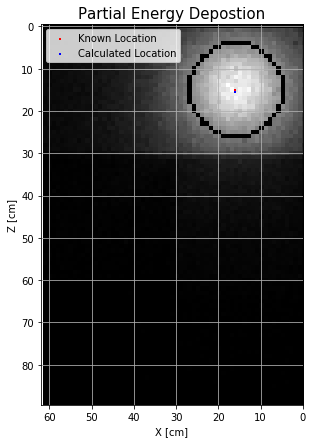

In [18]:
edges = canny(img2, sigma=6)
coords = np.column_stack(np.nonzero(edges))

model, inliers = measure.ransac(coords, measure.CircleModel, min_samples=3, residual_threshold=1, max_trials=1000)

print(model.params)

rr, cc = circle_perimeter(int(model.params[0]), int(model.params[1]), int(model.params[2]), shape=img2.shape)

img2[rr, cc] = 1

plt.clf()
plt.figure(figsize=(10,7))
plt.imshow(img2, cmap='gray')
plt.scatter(16, 15, s=5, c='r', marker="+", label='Known Location')
plt.scatter(model.params[1], model.params[0], s=5, c='b', marker="+", label='Calculated Location')
plt.grid(True)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.xlim(62,0)
plt.title('Partial Energy Depostion', fontsize=15)
plt.legend(loc='upper left')
plt.savefig('Images/Centroids/2Cent_Part_3fl_NW_10m.png', bbox_inches='tight')
plt.show()

In [19]:
d_error = (((16-model.params[1])**2)+((15-model.params[0])**2))*10
print(d_error)

2.7467878842616478
